# CO₂ Per Capita: Exploratory Data Analysis

This notebook explores global CO₂ emissions data from Our World in Data (OWID). The goals are to:

- Clean and impute missing data.

- Recompute derived features (per capita, per GDP, cumulative, global share).

- Perform **EDA** to uncover global, national, and sectoral trends.

- Identify key drivers of emissions (GDP, energy, population).

The workflow:

1. **Setup & Overview**

2. **Data Cleaning**

3. **EDA**

4. **Conclusions & Next Steps**

## 1. Setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")

# Load dataset
df = pd.read_csv("owid-co2-data.csv")

df.head()

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,Afghanistan,1750,AFG,2802560.0,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1751,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1752,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1753,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1754,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Overview

In [2]:
# Data types and shape
print("Shape:", df.shape)
print(df.dtypes)

# Check missing values
print("\nMissing values:\n", df.isna().sum())

# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Shape: (50191, 79)
country                         object
year                             int64
iso_code                        object
population                     float64
gdp                            float64
                                ...   
temperature_change_from_n2o    float64
total_ghg                      float64
total_ghg_excluding_lucf       float64
trade_co2                      float64
trade_co2_share                float64
Length: 79, dtype: object

Missing values:
 country                            0
year                               0
iso_code                        7929
population                      9172
gdp                            34940
                               ...  
temperature_change_from_n2o    12131
total_ghg                      12781
total_ghg_excluding_lucf       12955
trade_co2                      45656
trade_co2_share                45656
Length: 79, dtype: int64
Number of duplicate rows: 0


**Observation:**

- The dataset is large and multi-dimensional.

- Some variables contain significant missingness.

Because countries vary greatly in size, we will later focus on per-capita emissions as a fairer measure for comparison.

## 3. Data Cleaning

### 3.1 Countries Only

- Filter to actual sovereign countries.

- Exclude aggregate regions (Asia, OECD, EU, etc.).

In [3]:
# Keep only actual countries (exclude aggregates)
# Sovereign countries always have 3-letter ISO codes.
df = df[df['iso_code'].str.len() == 3]

print("Remaining entities:", df['country'].nunique())
print("Example countries:", df['country'].unique()[:10])

Remaining entities: 218
Example countries: ['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola' 'Anguilla'
 'Antarctica' 'Antigua and Barbuda' 'Argentina' 'Armenia']


### 3.2 Restricting Dataset to Post-1950

/tmp/ipython-input-1032474207.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_year = df.groupby("year").apply(lambda x: x.isna().mean().mean())


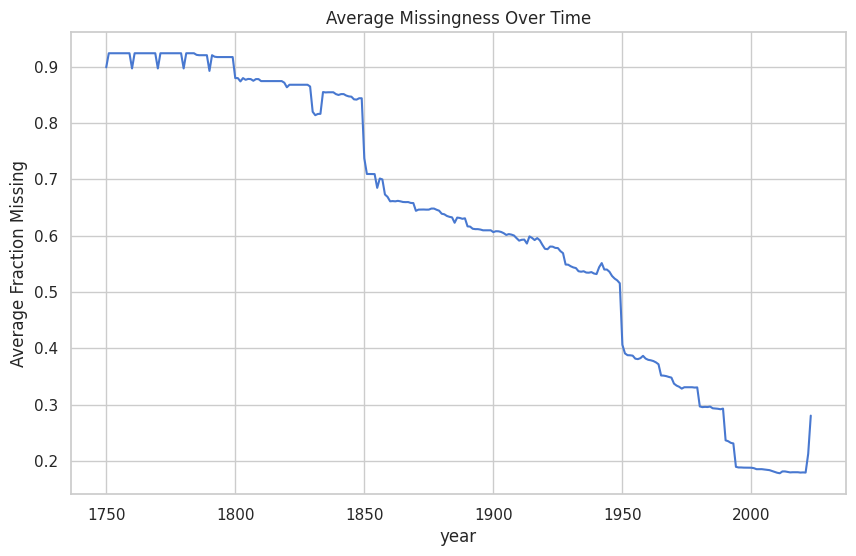

In [4]:
# Compute average missingness per year
missing_by_year = df.groupby("year").apply(lambda x: x.isna().mean().mean())
missing_by_year.plot(figsize=(10,6), title="Average Missingness Over Time")
plt.ylabel("Average Fraction Missing")
plt.show()

df = df[df['year'] > 1950]


**Observation:**

- Data completeness improves substantially after 1950, justifying this cutoff.

### 3.3 Feature Selection by Missingness

We categorize features into three groups based on the proportion of missing values:

- **High missingness (> 80%)** → drop

- **Medium missingness (30–80%)** → selectively drop

- **Low missingness (≤ 30%)** → impute

In [5]:
percent_missing = df.isna().sum() / df.shape[0]

high_missing = percent_missing[percent_missing > 0.8]
mid_missing = percent_missing[(percent_missing <= 0.8) & (percent_missing > 0.3)]
low_missing = percent_missing[percent_missing <= 0.3]

print("High Missing Features:\n", high_missing)
print("Medium Missing Features:\n", mid_missing)
print("Low Missing Features:\n", low_missing)

High Missing Features:
 cumulative_other_co2                 0.896695
other_co2_per_capita                 0.896695
other_industry_co2                   0.896695
share_global_cumulative_other_co2    0.901722
share_global_other_co2               0.901722
dtype: float64
Medium Missing Features:
 co2_including_luc_per_gdp              0.310921
co2_including_luc_per_unit_energy      0.452369
co2_per_gdp                            0.301873
co2_per_unit_energy                    0.412467
coal_co2                               0.358238
coal_co2_per_capita                    0.358238
consumption_co2                        0.752419
consumption_co2_per_capita             0.752419
consumption_co2_per_gdp                0.754619
cumulative_coal_co2                    0.358238
cumulative_flaring_co2                 0.409954
cumulative_gas_co2                     0.509489
energy_per_capita                      0.409074
energy_per_gdp                         0.517218
flaring_co2                      

**Decisions made:**

- Drop high-missing features: these are too sparse to be informative.

- Drop medium-missing sparse or derived features, e.g., trade- or consumption-based CO₂ metrics.

- Drop identifiers like iso_code as we now have countries.

In [6]:
# Drop high missing features
df.drop(columns=high_missing.index, inplace=True)
df.drop(columns=['iso_code'], inplace=True)

# Drop selected medium-missing sparse features
medium_drop = [
    'consumption_co2', 'consumption_co2_per_capita', 'consumption_co2_per_gdp',
    'trade_co2', 'trade_co2_share'
]
df.drop(columns=medium_drop, inplace=True)

### 3.4 Remove Potentially Leaky Features

Features derived from CO₂ or temperature changes can risk **data leakage**. We remove:

- Temperature change features

- Growth rate features

In [7]:
# Drop temperature change features
temperatures = [col for col in df.columns if 'temperature' in col]
df.drop(columns=temperatures, inplace=True)

# Drop growth features
growth = [col for col in df.columns if 'growth' in col]
df.drop(columns=growth, inplace=True)


### 3.5 Impute Raw Numeric Features

We define **raw features** as those directly measured rather than computed from other variables:

In [8]:
raw_features = [
    "population", "gdp",
    "cement_co2", "co2",
    "coal_co2", "flaring_co2", "gas_co2",
    "land_use_change_co2", "methane", "nitrous_oxide",
    "oil_co2", "primary_energy_consumption",
    "total_ghg", "total_ghg_excluding_lucf"
]


**Interpolation strategy:**

- 1. **Sort by country and year** for temporal consistency

- 2. **Interpolate missing values per country** using linear interpolation

- 3. **Fill any edge NaNs** with the median across all countries

In [9]:
df = df.sort_values(["country", "year"])

# Interpolate raw numeric features per country
df[raw_features] = (
    df.groupby("country", group_keys=False)[raw_features]
      .apply(lambda group: group.interpolate(method="linear", limit_direction="both"))
)

# Fill remaining NaNs with column median
df[raw_features] = df[raw_features].fillna(df[raw_features].median())

### 3.6 Recompute Derived Features

Many features are **derived from raw variables**, such as per capita, per GDP, cumulative, or global share metrics. We recompute them to ensure consistency after imputing raw features.

In [10]:
def recompute_derived_features(df):
    df = df.copy()

    # CO₂ including land use change
    df['co2_including_luc'] = df['co2'] + df['land_use_change_co2']

    # ---- Per capita ----
    per_capita_pairs = {
        "cement_co2": "cement_co2_per_capita",
        "co2": "co2_per_capita",
        "co2_including_luc": "co2_including_luc_per_capita",
        "coal_co2": "coal_co2_per_capita",
        "flaring_co2": "flaring_co2_per_capita",
        "gas_co2": "gas_co2_per_capita",
        "land_use_change_co2": "land_use_change_co2_per_capita",
        "methane": "methane_per_capita",
        "nitrous_oxide": "nitrous_oxide_per_capita",
        "oil_co2": "oil_co2_per_capita",
        "total_ghg": "ghg_per_capita",
        "total_ghg_excluding_lucf": "ghg_excluding_lucf_per_capita",
        "primary_energy_consumption": "energy_per_capita"
    }
    for raw, derived in per_capita_pairs.items():
        if raw in df.columns and derived in df.columns:
            df[derived] = df[raw] / df["population"]

    # ---- Per GDP ----
    gdp_pairs = {
        "co2": "co2_per_gdp",
        "co2_including_luc": "co2_including_luc_per_gdp",
        "primary_energy_consumption": "energy_per_gdp"
    }
    for raw, derived in gdp_pairs.items():
        if raw in df.columns and derived in df.columns:
            df[derived] = df[raw] / df["gdp"]

    # ---- Per unit energy ----
    energy_pairs = {
        "co2": "co2_per_unit_energy",
        "co2_including_luc": "co2_including_luc_per_unit_energy",
    }
    for raw, derived in energy_pairs.items():
        if raw in df.columns and derived in df.columns:
            df[derived] = df[raw] / df["primary_energy_consumption"]

    # ---- Cumulative totals ----
    cumulative_raws = [
        "cement_co2", "co2", "co2_including_luc", "coal_co2",
        "flaring_co2", "gas_co2", "land_use_change_co2", "oil_co2"
    ]
    for raw in cumulative_raws:
        cum_col = f"cumulative_{raw}"
        if raw in df.columns and cum_col in df.columns:
            df[cum_col] = df.groupby("country")[raw].cumsum()

    df["cumulative_luc_co2"] = df.groupby("country")["land_use_change_co2"].cumsum()

    # ---- Shares of global total ----
    share_raws = [
        "cement_co2", "co2", "co2_including_luc", "coal_co2",
        "flaring_co2", "gas_co2", "land_use_change_co2", "oil_co2"
    ]
    for raw in share_raws:
        share_col = f"share_global_{raw}"
        share_cum_col = f"share_global_cumulative_{raw}"
        cum_col = f"cumulative_{raw}"

        if raw in df.columns and share_col in df.columns:
            df[share_col] = df[raw] / df.groupby("year")[raw].transform("sum")
        if cum_col in df.columns and share_cum_col in df.columns:
            df[share_cum_col] = df[cum_col] / df.groupby("year")[cum_col].transform("sum")

    df["share_global_luc_co2"] = df["land_use_change_co2"] / df.groupby("year")["land_use_change_co2"].transform("sum")
    df["share_global_cumulative_luc_co2"] = df["cumulative_luc_co2"] / df.groupby("year")["cumulative_luc_co2"].transform("sum")

    return df

df = recompute_derived_features(df)


### 3.7 Verify Missingness

Finally, we check that all missing values have been imputed:

In [11]:
percent_missing_after = df.isna().sum() / df.shape[0]
print("Top 10 features by missingness after cleaning:\n", percent_missing_after.sort_values(ascending=False).head(10))

Top 10 features by missingness after cleaning:
 country                         0.0
year                            0.0
population                      0.0
gdp                             0.0
cement_co2                      0.0
cement_co2_per_capita           0.0
co2                             0.0
co2_including_luc               0.0
co2_including_luc_per_capita    0.0
co2_including_luc_per_gdp       0.0
dtype: float64


## 4. 🌍 Exploratory Data Analysis (EDA)

Now that our dataset has been cleaned and imputed, we perform Exploratory Data Analysis (EDA) to understand the structure of the data, detect trends, and uncover relationships that may be useful for modeling CO₂ emissions.

### 4.1 Dataset Summary

We begin by reviewing the size of the dataset, summary statistics, and the distinction between raw and derived features.

In [12]:
print("Shape of dataset:", df.shape)

# Summary statistics
display(df.describe().T.head(10))

derived_features = [col for col in df.columns if col not in raw_features + ["country", "year"]]

print("Number of raw features:", len(raw_features))
print("Number of derived features:", len(derived_features))

Shape of dataset: (15914, 59)


,count,mean,std,min,25%,50%,75%,max
year,15914.0,1.987000e+03,2.107197e+01,1.951000e+03,1.969000e+03,1.987000e+03,2.005000e+03,2.023000e+03
population,15914.0,2.358032e+07,1.001342e+08,5.010000e+02,4.465702e+05,4.024452e+06,1.263619e+07,1.438070e+09
gdp,15914.0,2.396935e+11,1.099984e+12,5.543200e+07,1.580553e+10,3.430776e+10,8.653507e+10,2.696602e+13
cement_co2,15914.0,2.986205e+00,2.588591e+01,0.000000e+00,0.000000e+00,1.130000e-01,9.987500e-01,8.499760e+02
cement_co2_per_capita,15914.0,9.492613e-07,1.086667e-05,0.000000e+00,0.000000e+00,2.513761e-08,1.330915e-07,2.255489e-04
co2,15914.0,9.656209e+01,5.081264e+02,0.000000e+00,4.140000e-01,3.866000e+00,3.368925e+01,1.190250e+04
co2_including_luc,15914.0,1.280159e+02,5.441983e+02,-9.969300e+01,2.376250e+00,1.430950e+01,5.935275e+01,1.160593e+04
co2_including_luc_per_capita,15914.0,4.516866e-05,3.746082e-04,-1.317467e-05,1.760726e-06,4.598184e-06,1.056679e-05,7.716567e-03
co2_including_luc_per_gdp,15914.0,1.191405e-09,3.284147e-09,-6.469107e-09,1.182026e-10,3.959839e-10,1.020170e-09,8.257993e-08
co2_including_luc_per_unit_energy,15914.0,inf,NaN,-1.318151e+01,1.710461e-01,2.863777e-01,1.194658e+00,inf


Number of raw features: 14
Number of derived features: 43


**Observation:**

- CO₂ emissions, GDP, and population vary across several orders of magnitude, suggesting need for log-scaling.

### 4.2 CO₂ Distribution

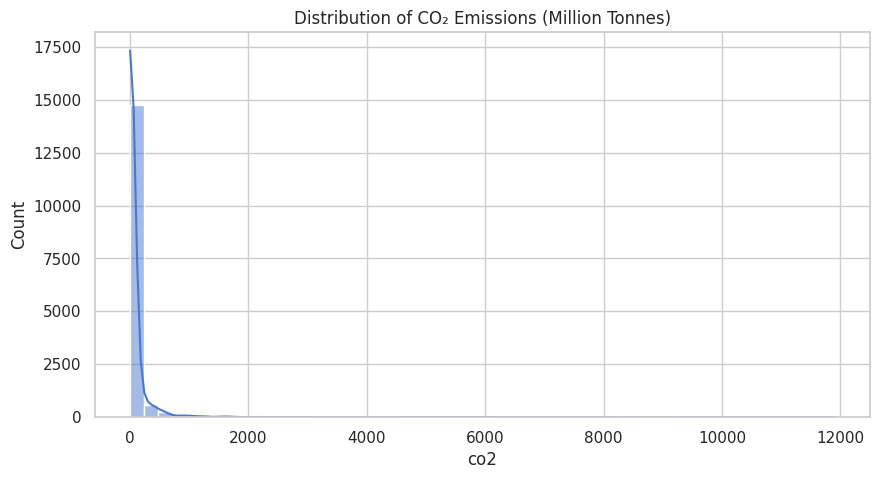

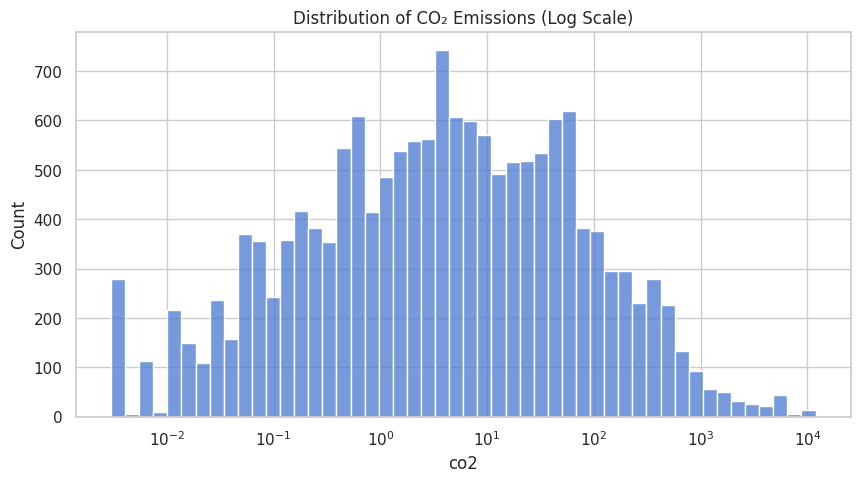

In [13]:
plt.figure(figsize=(10,5))
sns.histplot(df["co2"].dropna(), bins=50, kde=True)
plt.title("Distribution of CO₂ Emissions (Million Tonnes)")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df["co2"].dropna(), bins=50, log_scale=True)
plt.title("Distribution of CO₂ Emissions (Log Scale)")
plt.show()


**Observation:**

- Raw distribution is heavily right-skewed. Log scaling reveals a more normal spread, enabling clearer comparisons.

While total CO₂ distributions show the scale of emissions, per-capita emissions will provide the focus for modelling since they highlight inequality between countries.

### 4.3 Global Trends

We aggregate emissions globally to understand long-term dynamics.

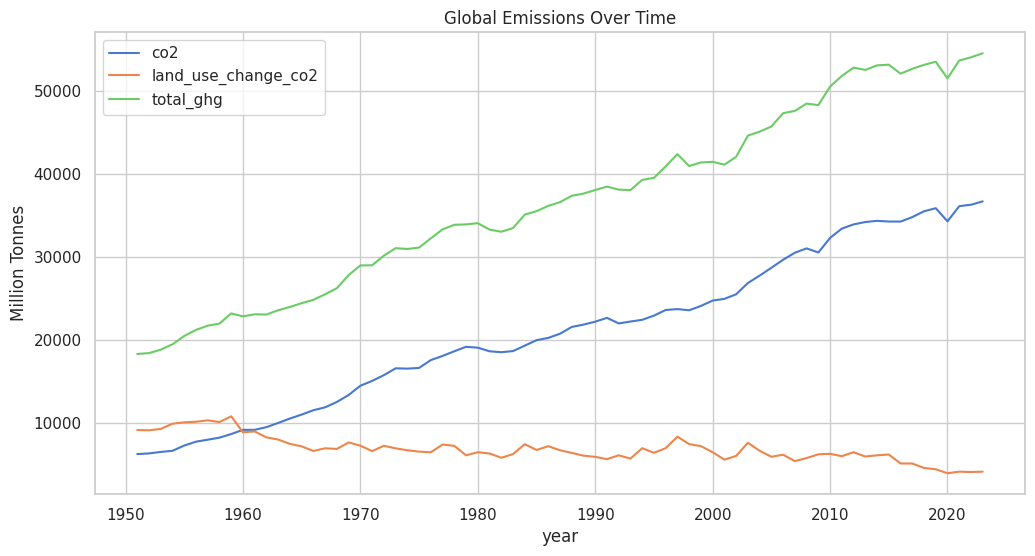

In [14]:
global_trend = df.groupby("year")[["co2", "land_use_change_co2", "total_ghg"]].sum()

global_trend.plot(figsize=(12,6))
plt.title("Global Emissions Over Time")
plt.ylabel("Million Tonnes")
plt.show()


**Observation:**

- Global CO₂ has increased steeply since 1950, though growth has slowed in recent decades. Land-use emissions contribute less today than fossil fuels.

### 4.4 Country-Level Trends

Next, we focus on country-level emissions to see which nations dominate CO₂ output.

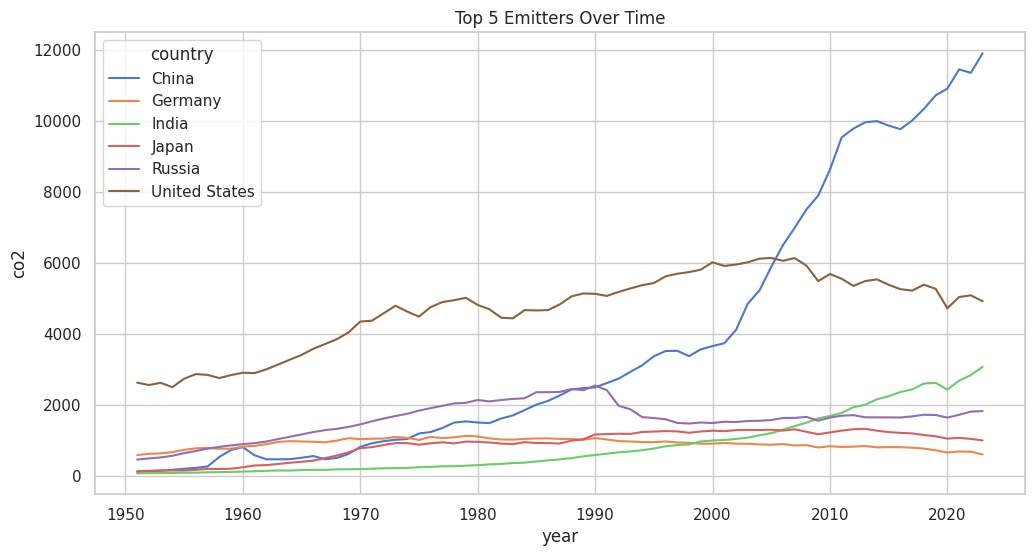

In [15]:
# Top 5 total emitters
top_emitters = df.groupby("country")["co2"].sum().nlargest(6).index
subset = df[df["country"].isin(top_emitters)]

plt.figure(figsize=(12,6))
sns.lineplot(data=subset, x="year", y="co2", hue="country")
plt.title("Top 5 Emitters Over Time")
plt.show()


**Observation:**

- The U.S. dominated early emissions; China overtook around 2005. India’s contribution is growing rapidly.

### 4.5 Drivers of Emissions

We explore how key factors like GDP, population, and energy consumption relate to CO₂ emissions.

**Observations:**

- Strong log-linear relationship: GDP ↔ CO₂ and Energy ↔ CO₂.

- Population ↔ CO₂ is weaker, indicating economic activity and energy use are stronger direct drivers.


### 4.6 Country Comparisons

We compare total vs. per-capita emissions across countries.

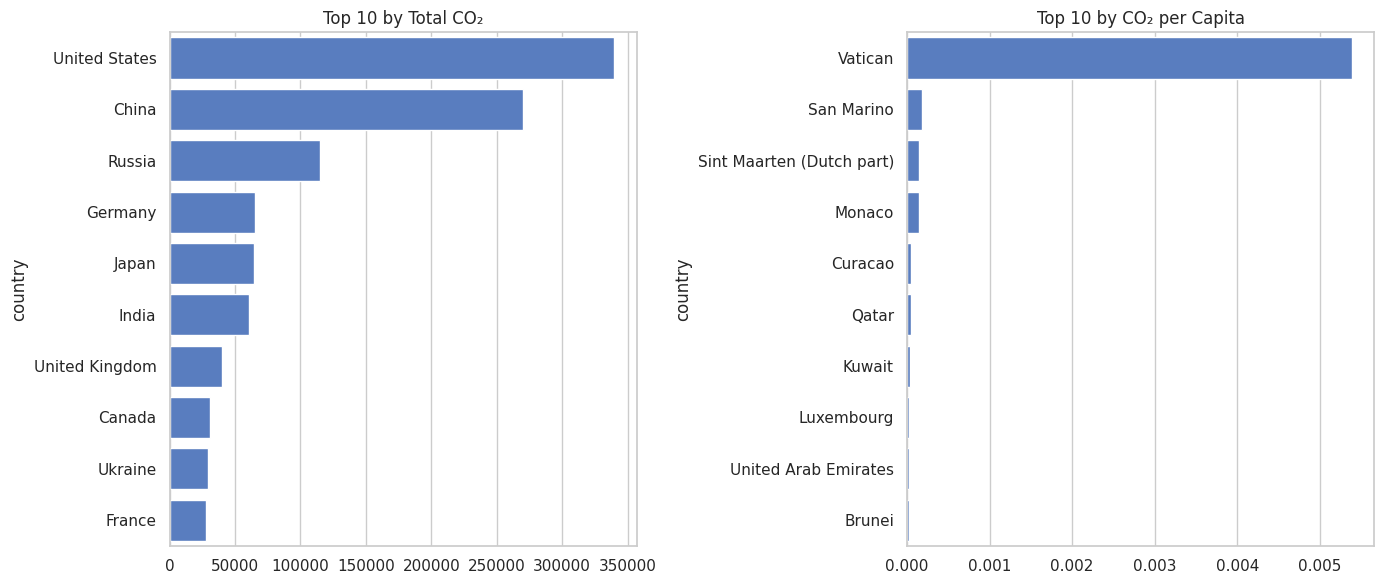

In [16]:
rank_total = df.groupby("country")["co2"].sum().nlargest(10)
rank_per_capita = df.groupby("country")["co2_per_capita"].mean().nlargest(10)

fig, axes = plt.subplots(1,2, figsize=(14,6))
sns.barplot(x=rank_total.values, y=rank_total.index, ax=axes[0]); axes[0].set_title("Top 10 by Total CO₂")
sns.barplot(x=rank_per_capita.values, y=rank_per_capita.index, ax=axes[1]); axes[1].set_title("Top 10 by CO₂ per Capita")
plt.tight_layout(); plt.show()



**Observation:**

- Top emitters by total differ from per capita — e.g., small very wealthy states rank high per capita despite small total emissions.

- Per-capita emissions reveal stark inequality (e.g., Qatar vs. India), motivating our modelling focus.

### 4.7 Cumulative and Share of Global Emissions

We examine cumulative contributions and shares of global CO₂ emissions.

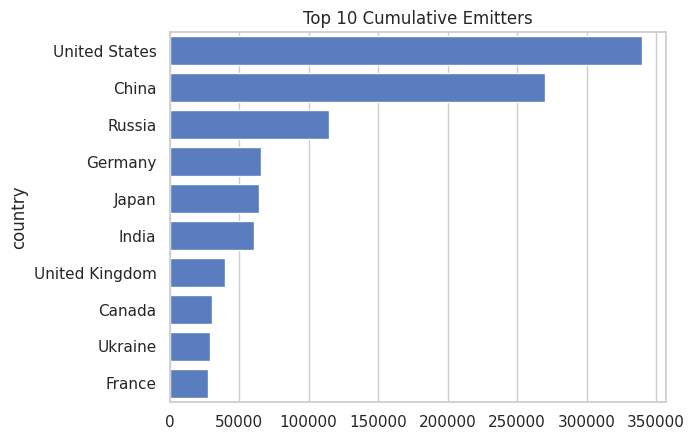

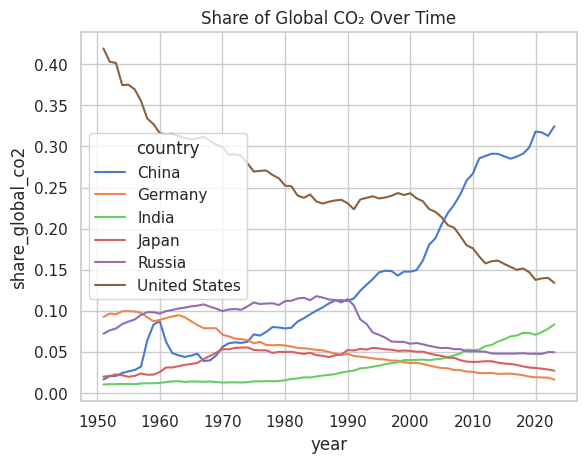

In [17]:
cum = df.groupby("country")["cumulative_co2"].max().nlargest(10)
sns.barplot(x=cum.values, y=cum.index); plt.title("Top 10 Cumulative Emitters"); plt.show()

share_subset = df[df["country"].isin(top_emitters)]
sns.lineplot(data=share_subset, x="year", y="share_global_co2", hue="country")
plt.title("Share of Global CO₂ Over Time"); plt.show()



**Observation:**

- Historically, the U.S. accounts for the largest cumulative emissions.
- China’s share of annual emissions surged from ~10% in 1990s to ~30% today.

However, cumulative per-capita emissions provide another fairness lens and could be explored in extensions.

### 4.8 Correlation Analysis

We check correlations among raw features to understand dependencies.

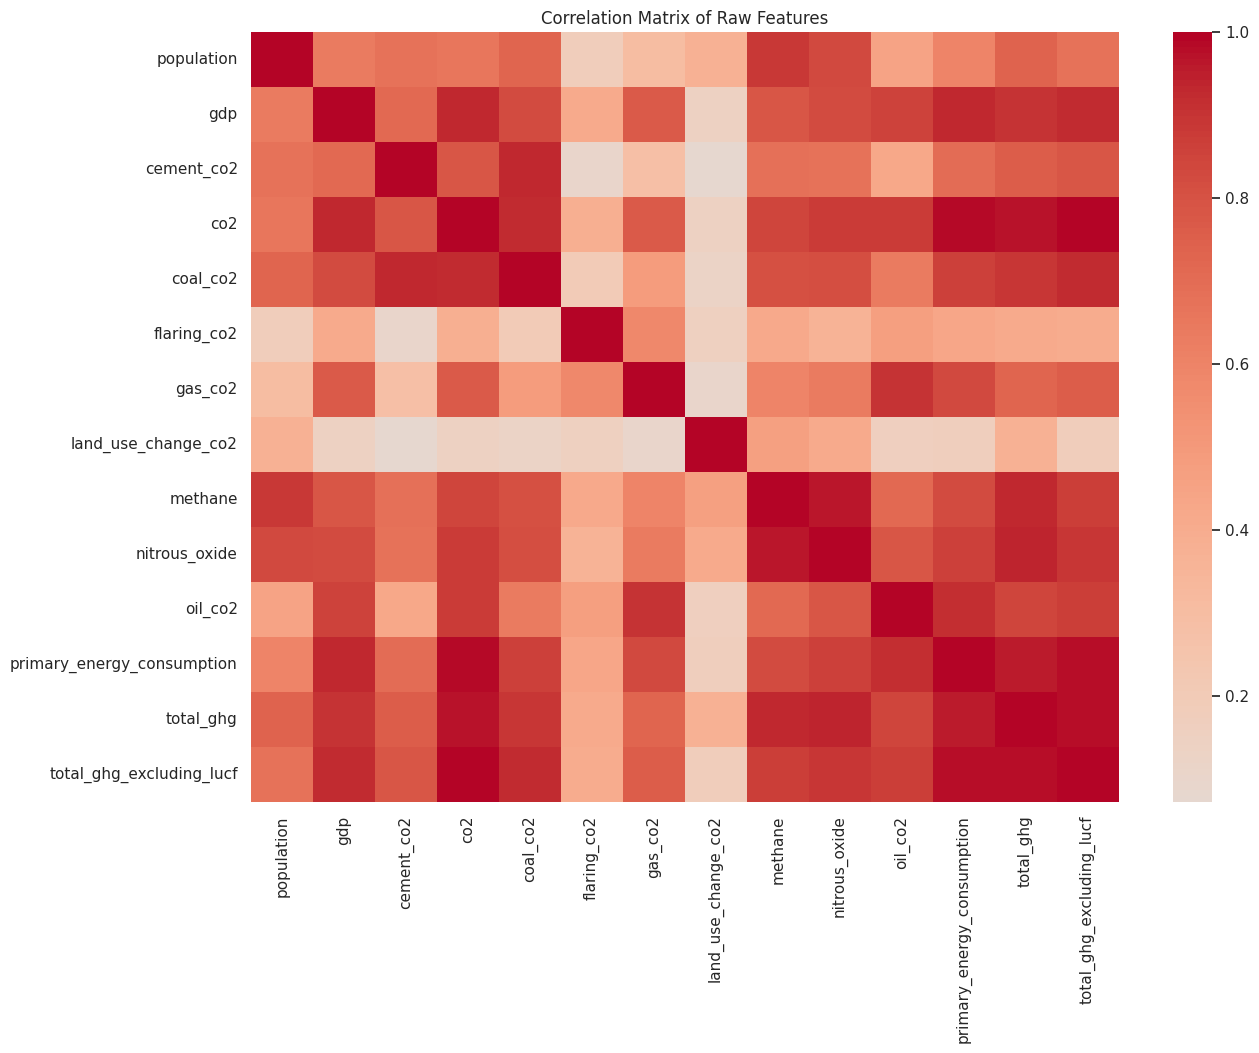

In [18]:
plt.figure(figsize=(14,10))
sns.heatmap(df[raw_features].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Raw Features")
plt.show()


**Observation:**

- CO₂ is highly correlated with GDP and energy consumption, confirming these as dominant predictors. Methane/nitrous oxide show weaker links.

Similar relationships hold for per-capita CO₂, reinforcing their importance as features in predictive modelling.

### 4.9 Outlier Detection

We identify countries or years with unusually high per-capita emissions.

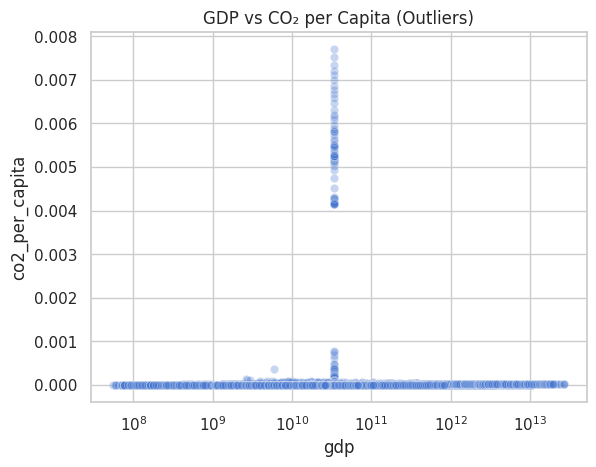

Top per-capita emitters:
 country
Vatican                      0.007717
Sint Maarten (Dutch part)    0.000783
Kuwait                       0.000365
San Marino                   0.000294
Monaco                       0.000190
Qatar                        0.000122
Curacao                      0.000118
United Arab Emirates         0.000086
Andorra                      0.000076
Brunei                       0.000068
Name: co2_per_capita, dtype: float64


In [19]:
# GDP vs CO2 per capita
sns.scatterplot(data=df, x="gdp", y="co2_per_capita", alpha=0.3)
plt.xscale("log"); plt.title("GDP vs CO₂ per Capita (Outliers)")
plt.show()

top_outliers = df.groupby("country")["co2_per_capita"].max().nlargest(10)
print("Top per-capita emitters:\n", top_outliers)



**Observation:**

- The Vatican is an extreme per-capita outliers relative to GDP. Oil-rich states (e.g., Qatar, Kuwait) are other outliers.

### 4.10 Emissions by Source

Finally, we look at the composition of emissions by source (coal, oil, gas, etc.).

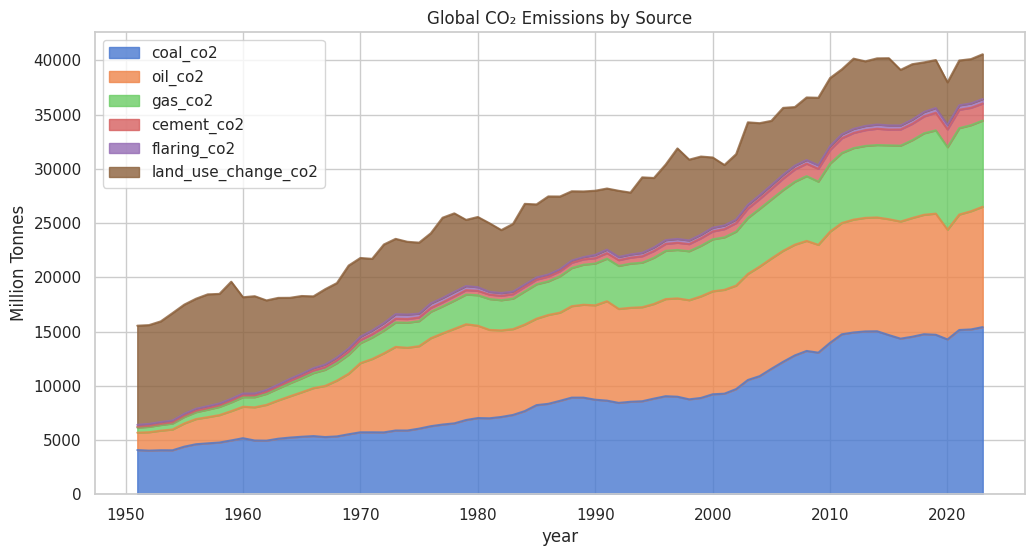

In [20]:
sources = ["coal_co2","oil_co2","gas_co2","cement_co2","flaring_co2","land_use_change_co2"]
global_sources = df.groupby("year")[sources].sum()

global_sources.plot.area(figsize=(12,6), alpha=0.8)
plt.title("Global CO₂ Emissions by Source")
plt.ylabel("Million Tonnes")
plt.show()

**Observation:**

- Pre-1970: Land use change dominated.

- 1970–2000: Oil and coal became the largest contributors.

- Post-2000: Gas is rising steadily, while coal remains significant.

## 5. Conclusions & next Steps

**Key Findings:**

- **Global emissions** rose sharply post-1950, with fossil fuels overtaking land use as main drivers; however, per-capita emissions reveal deep inequalities in contribution.

- **GDP and energy consumption** are the strongest predictors of CO₂, stronger than population.

- **Country variation** is stark — top emitters by total differ from per capita, highlighting inequality in contributions.

- **Cumulative emissions** underscore historical responsibility, with the U.S. far ahead despite China’s recent rise.

- **Sectoral sources** show coal, oil, and gas as critical intervention points for future mitigation.

**Next Steps:**

- **Model training:** Build predictive models to quantify the relationship between per-capita CO₂ emissions and their key drivers (GDP, energy consumption, population).

- **Feature engineering:** Leverage both raw and derived features (e.g., per-capita, per-GDP measures) to capture structural differences between countries.

- **Comparative analysis:** Evaluate model performance across countries and regions to understand differences in drivers of emissions.

- **Scenario testing:** Use models to simulate “what-if” scenarios (e.g., changes in energy mix, economic growth, or population).

- **Policy relevance:** Translate model outputs into insights on where interventions (energy efficiency, fuel switching, or economic restructuring) could have the largest impact.

## 6. Export Cleaned Dataset

In [21]:
df.to_csv('dataset_cleaned.csv', index=False)